# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pbank) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

#### Answer 1:
"**17 campaigns** that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts"

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from imblearn.over_sampling import SMOTE
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

In [2]:
bank = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
pd.options.display.max_columns = None

In [4]:
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



#### Data Cleaning and Transformation

In [5]:
bank.y.value_counts()

no     36548
yes     4640
Name: y, dtype: int64

#### Analyze Features
Some features have unknown values, this may impact the models, by checking the feature importance chart, I will assign null to less important features, remove those null tuples from the dataset. Especially, `loan` and `housing`.

| Feature | Importance |
| ------- | ---------- |
|	default|0.018551 |
|	age	|0.005844 |
|	job	|0.004646 |
|	education	|0.002443|
|	marital	|0.000730|
|	housing	|0.000202|
|	loan	|0.000075|

In [6]:
def plot_by_feature(feature, rotate=0):
    plt.subplots(figsize=(16,6))
    splot = sns.countplot(data=bank, x=feature, hue = 'y')
    plt.xlabel('Accepted Marketing Campaign by ' + feature.capitalize())
    plt.xticks(rotation = 90)
    plt.ylabel(feature.capitalize() + ' Count')
    plt.title('Acceptance of Marketing Campaign by ' + feature.capitalize())
    plt.show()

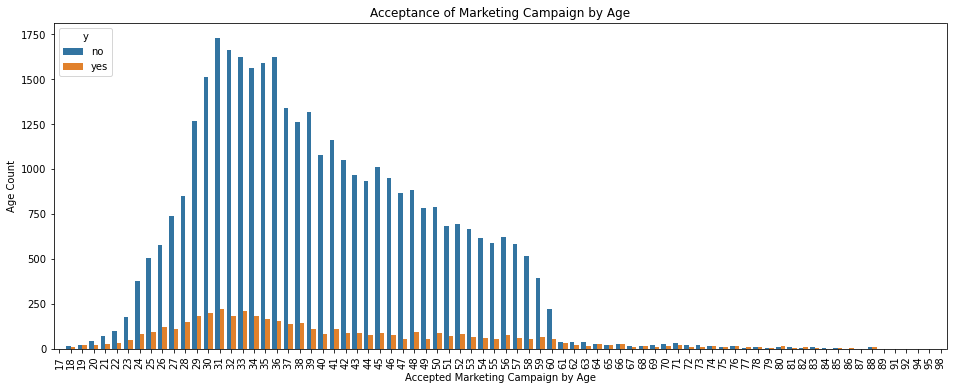

In [7]:
plot_by_feature('age')

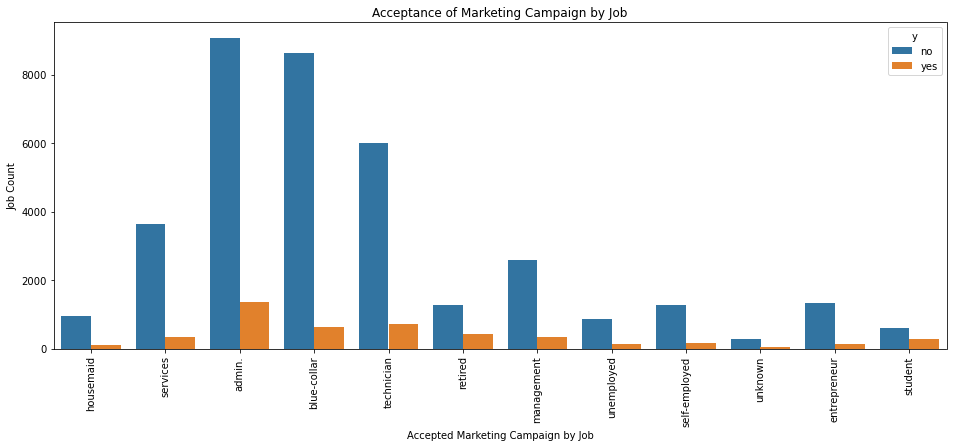

In [8]:
plot_by_feature('job')

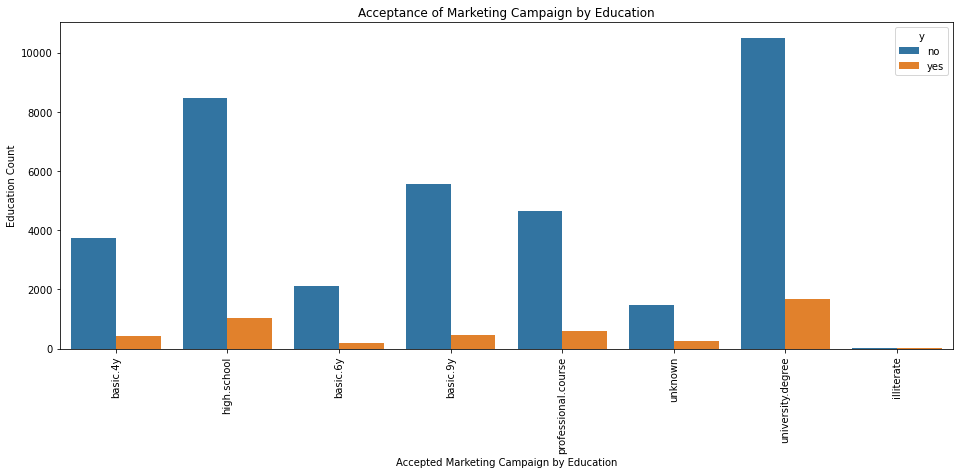

In [9]:
plot_by_feature('education')

Senior people accept campaigns more, also illiterate people, professions seem to keep the same ratio!

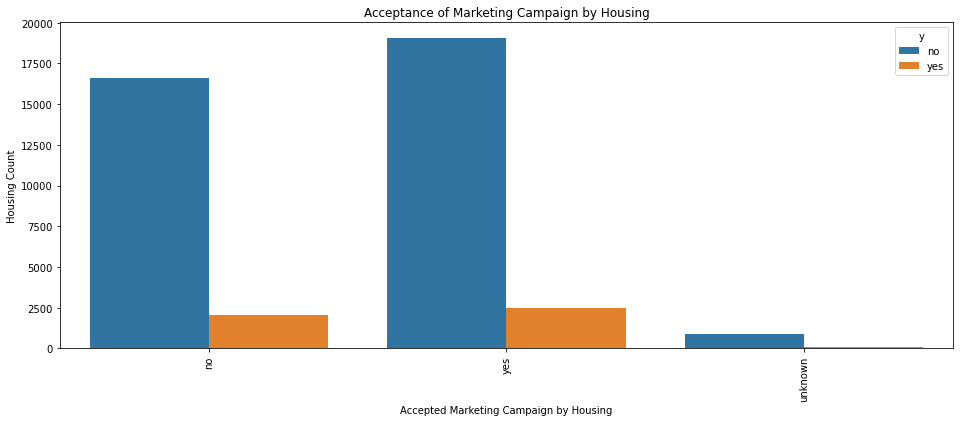

In [10]:
plot_by_feature('housing')

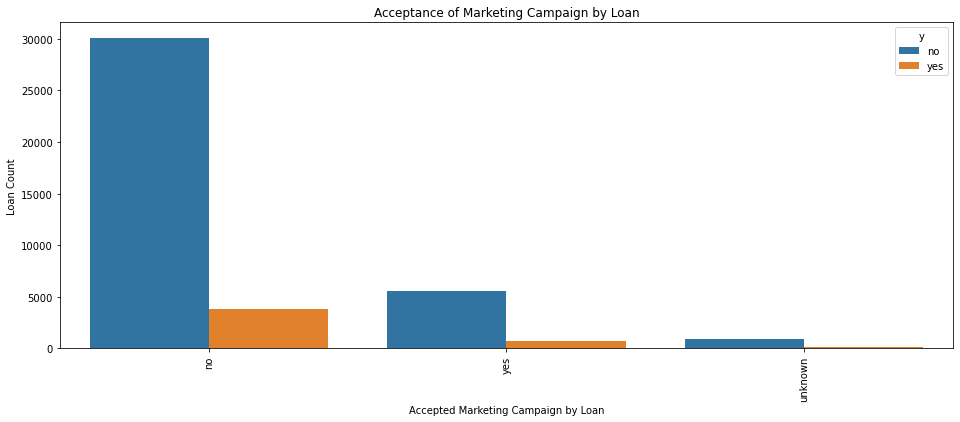

In [11]:
plot_by_feature('loan')

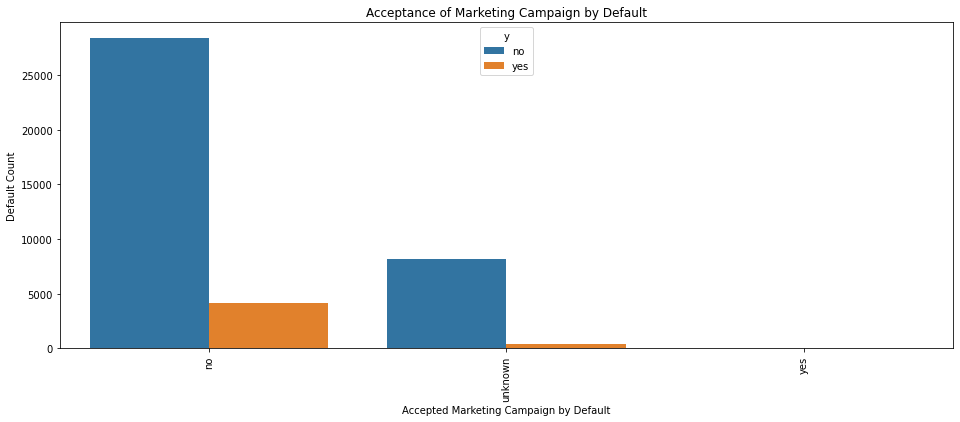

In [12]:
plot_by_feature('default')

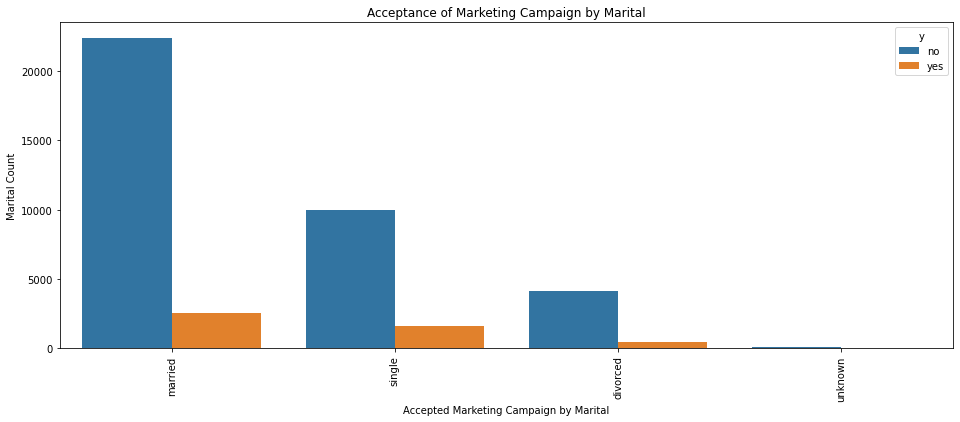

In [13]:
plot_by_feature('marital')

In [14]:
tstart = datetime.now()
print(tstart)

2022-07-18 12:20:54.234541


#### Transform Values
Removing `unknown` in `default`, `loan`, and `housing` would be considered if I kept those features in the dataset.

In [15]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [16]:
# Transform job to numeric by factorize, no need for mapping!
#bank['job'].replace('unknown', np.NaN, inplace = True)
bank['job'] = bank['job'].factorize()[0]
# asign null again for -1 which is unknown
#bank['job'].replace(-1, np.NaN, inplace = True)

In [17]:
# Transform marital to numeric by factorize, no need for mapping!
# keep unknown in marital
bank['marital'] = bank['marital'].factorize()[0]

In [18]:
# education
# keep unknown in education!
bank['education'] = bank['education'].map({'basic.4y':2,'basic.6y':3,'basic.9y':4,'high.school':5,'illiterate':1,
                                           'professional.course':6,'university.degree':7,'unknown':0})

In [19]:
# map yes/no/unknown columns default, housing, loan, keep unknown values!
#mapping = {'no':1,'yes':2,'unknown':np.NaN}
mapping = {'no':1,'yes':2,'unknown':0}
bank['default'] = bank['default'].map(mapping)
bank['housing'] = bank['housing'].map(mapping)
bank['loan'] = bank['loan'].map(mapping)

In [20]:
# contact
bank['contact'] = bank['contact'].map({'cellular':1,'telephone':0})

In [21]:
# month
bank['month'] = bank['month'].map({'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9,
                                   'oct':10, 'nov':11, 'dec':12})

In [22]:
# day_of_week
bank['day_of_week'] = bank['day_of_week'].map({'mon':1,'tue':2,'wed':3,'thu':4,'fri':5})

In [23]:
# poutcome
bank['poutcome'] = bank['poutcome'].map({'failure':1,'nonexistent':0,'success':2})

In [24]:
# target column yes/no to 1/0
bank['y'] = bank['y'].map({'no':0, 'yes':1})

In [25]:
# drop null values
bank.dropna(inplace = True)

In [26]:
# final outcome before removing duplicates
bank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  int64  
 2   marital         41188 non-null  int64  
 3   education       41188 non-null  int64  
 4   default         41188 non-null  int64  
 5   housing         41188 non-null  int64  
 6   loan            41188 non-null  int64  
 7   contact         41188 non-null  int64  
 8   month           41188 non-null  int64  
 9   day_of_week     41188 non-null  int64  
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  int64  
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

#### Check and Remove Duplicates!

In [27]:
bank = bank.drop_duplicates()

#### Check Feature Overlapping
Group bank data to see if any feature overlapping exists against 2 different target values.

In [28]:
bank.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [83]:
# group by 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan', and target column 'y'
# then group the outcome list again without the target column to see if any features overlap in two classes
# 0 through 6 columns are not distinctive enough for modeling!
bank_size = bank.groupby(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'y']).size().groupby(
    ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']).size().reset_index()
bank_size = bank_size[bank_size[0]>1][['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']]
bank_size

,age,job,marital,education,default,housing,loan
5,18,11,1,0,1,1,1
6,18,11,1,0,1,2,1
9,18,11,1,2,1,2,1
14,18,11,1,4,1,2,1
15,18,11,1,5,1,1,1
...,...,...,...,...,...,...,...
12971,85,0,0,2,0,1,1
12975,85,5,0,2,1,1,1
12979,85,5,2,2,0,2,1
12993,88,5,2,2,1,2,1


In [84]:
# Find out how many data entries is in the overlapped category to see how good a model could be
# These cannot be correctly classified
print('Overlapped Features Rate:', \
    len(bank.merge(bank_size, on = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan'])) / len(bank))
print('Overlapped Features Rows:', \
    len(bank.merge(bank_size, on = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan'])))

Overlapped Features Rate: 0.47425684864969886
Overlapped Features Rows: 19528


This is an indicator that 47% of data cannot be properly classified whereas 53% can be for the simple model.

In [31]:
# Add some more features to have clear boundaries between two distinctive classes
# Please note that duration is not included in the entire dataset since it is an after-the-fact feature!
# There are still 237 overlapping features for different classes
bank_size = bank.groupby(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']).size().groupby(
    ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed']).size().reset_index()
bank_size[bank_size[0]>1]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,0
423,23,2,1,6,1,2,1,1,7,3,2,999,0,0,1.4,93.918,-42.7,4.963,5228.1,2
471,23,3,1,4,1,2,1,1,5,1,1,999,0,0,-1.8,92.893,-46.2,1.299,5099.1,2
480,23,3,1,5,1,1,1,1,7,3,1,999,0,0,1.4,93.918,-42.7,4.957,5228.1,2
485,23,3,1,5,1,2,1,1,7,3,1,999,0,0,1.4,93.918,-42.7,4.957,5228.1,2
512,23,6,1,7,1,1,1,1,7,4,2,999,0,0,1.4,93.918,-42.7,4.958,5228.1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38444,63,5,0,5,1,1,1,1,10,3,1,999,0,0,-3.4,92.431,-26.9,0.740,5017.5,2
38962,76,6,0,0,1,1,1,1,9,5,1,999,0,0,-3.4,92.379,-29.8,0.803,5017.5,2
39082,82,5,0,7,1,2,1,1,10,2,1,999,0,0,-3.4,92.431,-26.9,0.744,5017.5,2
39084,82,5,1,2,1,2,1,1,10,4,2,999,0,0,-3.4,92.431,-26.9,0.722,5017.5,2


In [32]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  int64  
 2   marital         41176 non-null  int64  
 3   education       41176 non-null  int64  
 4   default         41176 non-null  int64  
 5   housing         41176 non-null  int64  
 6   loan            41176 non-null  int64  
 7   contact         41176 non-null  int64  
 8   month           41176 non-null  int64  
 9   day_of_week     41176 non-null  int64  
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  int64  
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null 

In [33]:
bank.y.value_counts(normalize = True)

0    0.887337
1    0.112663
Name: y, dtype: float64

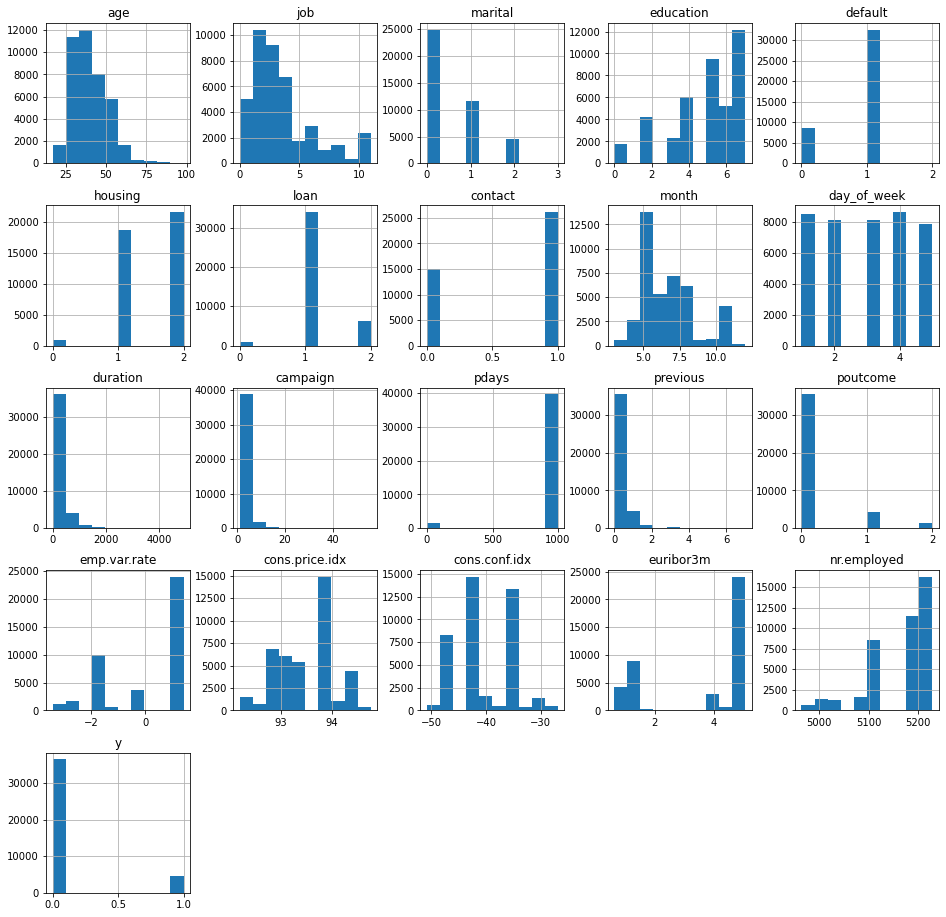

In [34]:
bank.hist(figsize = (16, 16))
plt.show()

In [35]:
bank.describe()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,3.673863,0.510637,4.943924,0.791310,1.499830,1.127696,0.634714,6.607733,2.979600,258.315815,2.567879,962.464810,0.173013,0.169953,0.081922,93.575720,-40.502863,3.621293,5167.034870,0.112663
std,10.42068,2.454340,0.696794,1.909281,0.406556,0.545979,0.399349,0.481516,2.041013,1.411539,259.305321,2.770318,186.937102,0.494964,0.455811,1.570883,0.578839,4.627860,1.734437,72.251364,0.316184
min,17.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,2.000000,0.000000,4.000000,1.000000,1.000000,1.000000,0.000000,5.000000,2.000000,102.000000,1.000000,999.000000,0.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,3.000000,0.000000,5.000000,1.000000,2.000000,1.000000,1.000000,6.000000,3.000000,180.000000,2.000000,999.000000,0.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,4.000000,1.000000,7.000000,1.000000,2.000000,1.000000,1.000000,8.000000,4.000000,319.000000,3.000000,999.000000,0.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,11.000000,3.000000,7.000000,2.000000,2.000000,2.000000,1.000000,12.000000,5.000000,4918.000000,56.000000,999.000000,7.000000,2.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


<AxesSubplot:>

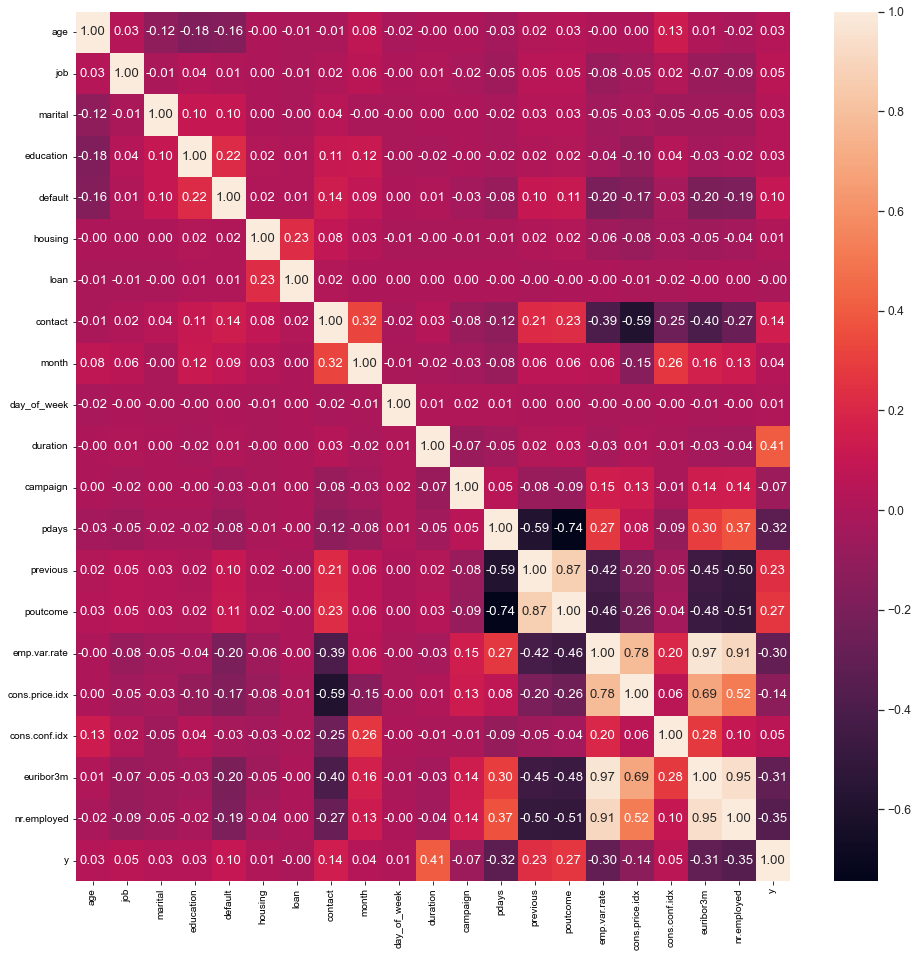

In [36]:
#heatmap
plt.subplots(figsize=(16,16))
sns.set(font_scale=1.1)
sns.heatmap(bank.corr(), annot=True, fmt='.2f')

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

### Business Objective
Due to domestic competition and current financial crisis, there is a huge pressure on European banks to increase financial asset. To solve this issue, one adopted strategy is to offer attractive long-term deposit applications with good interest rates, particularly by using directed marketing campaigns. Also, the same economic factors apply for cost reduction and time. Thus, there is a need for **improvement in efficiency**: `lesser customer contacts must be done, but same success rate` (clients subscribing to the deposit) `must be maintained`.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [37]:
# data was transformed above already, so just copy columns 1-7 and y to X, y
# features from 0 through 6
X, y = bank.iloc[:, 0:7], bank.y
X

,age,job,marital,education,default,housing,loan
0,56,0,0,2,1,1,1
1,57,1,0,5,0,1,1
2,37,1,0,5,1,2,1
3,40,2,0,3,1,1,1
4,56,1,0,5,1,1,2
...,...,...,...,...,...,...,...
41183,73,5,0,6,1,2,1
41184,46,3,0,6,1,1,1
41185,56,5,0,7,1,2,1
41186,44,4,0,6,1,1,1


In [38]:
# Scale dataframe
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [39]:
X.shape, X_scaled.shape

((41176, 7), (41176, 7))

In [40]:
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled

,age,job,marital,education,default,housing,loan
0,1.533143,-1.496903,-0.732848,-1.541920,0.513317,-0.915485,-0.319764
1,1.629107,-1.089456,-0.732848,0.029371,-1.946398,-0.915485,-0.319764
2,-0.290177,-1.089456,-0.732848,0.029371,0.513317,0.916108,-0.319764
3,-0.002284,-0.682010,-0.732848,-1.018156,0.513317,-0.915485,-0.319764
4,1.533143,-1.089456,-0.732848,0.029371,0.513317,-0.915485,2.184342
...,...,...,...,...,...,...,...
41183,3.164534,0.540330,-0.732848,0.553134,0.513317,0.916108,-0.319764
41184,0.573501,-0.274563,-0.732848,0.553134,0.513317,-0.915485,-0.319764
41185,1.533143,0.540330,-0.732848,1.076898,0.513317,0.916108,-0.319764
41186,0.381573,0.132883,-0.732848,0.553134,0.513317,-0.915485,-0.319764


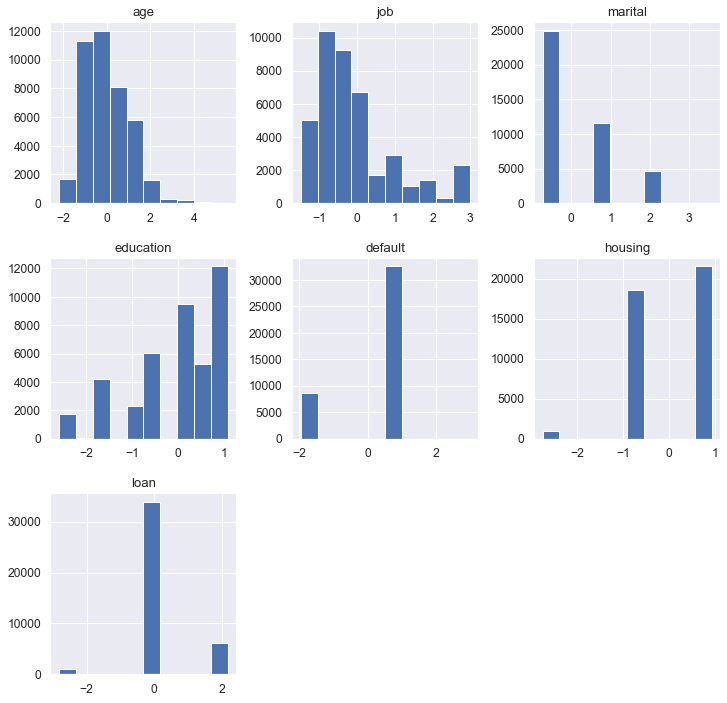

In [41]:
X_scaled.hist(figsize = (12, 12))
plt.show()

<AxesSubplot:>

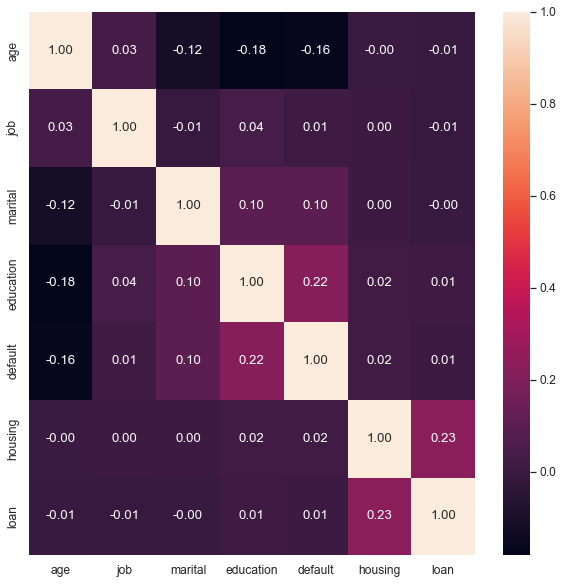

In [42]:
#heatmap
plt.subplots(figsize=(10,10))
sns.set(font_scale=1.1)
sns.heatmap(X_scaled.corr(), annot=True, fmt='.2f')

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [43]:
# use scaled dataset to split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 93, test_size = 0.3, stratify = y)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [44]:
y.value_counts(normalize = True)

0    0.887337
1    0.112663
Name: y, dtype: float64

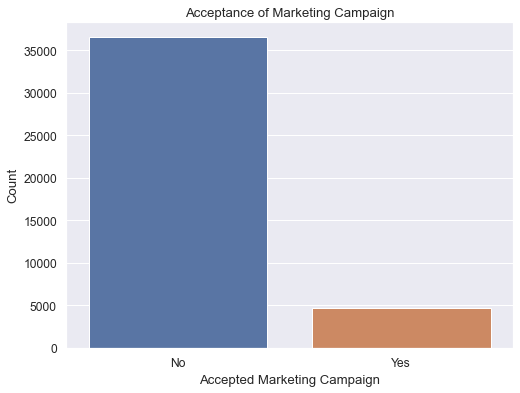

In [45]:
plt.subplots(figsize=(8,6))
splot = sns.countplot(data=bank, x = 'y')
splot.set_xticklabels(['No', 'Yes'])
plt.xlabel('Accepted Marketing Campaign')
plt.ylabel('Count')
plt.title('Acceptance of Marketing Campaign')
plt.show()

The baseline is **0.887337** by value counts function as well as the target values outlined in the count plot, the model should be better than this baseline! However, the feature overlapping above indicates only 53% can be properly classified, 47% being arbitrarily due to feature overlapping. If we assume 50-50, best we can get is **`77%`** for this dataset as `baseline`.

In [46]:
# model executor
# it uses X_train, y_train and X_test, y_test sets automatically!
def model_executor(model, cv_cnt, params, scorer, jobs=1):
    model_grid = GridSearchCV(model, cv = cv_cnt, param_grid = params,
                              scoring = scorer, n_jobs = jobs).fit(X_train, y_train)
    model_train = model_grid.score(X_train, y_train)
    model_test = model_grid.score(X_test, y_test)
    model_time = np.mean(model_grid.cv_results_['mean_fit_time'])
    model_params = model_grid.best_params_
    model_results = model_grid.cv_results_

    # results
    print(f'Training Accuracy: {model_train: .5f}')
    print(f'Test Accuracy    : {model_test: .5f}')
    print(f'Average Fit Time : {model_time: .5f}')
    print(f'Best parameters @ {scorer} of {model}: {model_params}')

    # confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test, model_grid.predict(X_test), display_labels=['No', 'Yes'])
    plt.title('Confusion Matrix')
    plt.grid(False)
    plt.show()

    return model_grid, model_train, model_test, model_time, model_params, model_results

In [47]:
# set scorer for GridSearchCV()
scorer = 'recall'
#scorer = 'roc_auc'

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

#### LogisticRegression

In [48]:
lgr = LogisticRegression()
cv_fold = 5

Training Accuracy:  0.00000
Test Accuracy    :  0.00000
Average Fit Time :  0.01343
Best parameters @ recall of LogisticRegression(): {'C': 1}


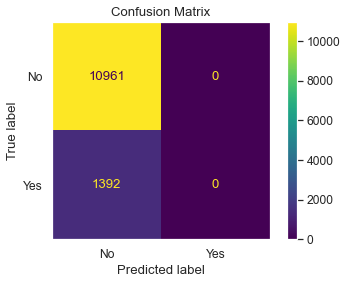

CPU times: user 1.86 s, sys: 43.4 ms, total: 1.9 s
Wall time: 249 ms


In [49]:
%%time
# Default hyperparameter values for LogisticRegression()
params = {'C':[1]}
lgr_grid, lgr_train, lgr_test, lgr_time, lgr_params, lgr_results = model_executor(lgr, cv_fold, params, scorer)

### Problem 9: Score the Model

What is the accuracy of your model?

In [50]:
print(f'Test Accuracy    : {lgr_test: .5f}')

Test Accuracy    :  0.00000


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:


|	Model |	Train Time |	Train Accuracy |	Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|	Logistic Regression |	0.113987 |	0.616186 |	0.621731 |
|	KNN |	0.025383 |	0.794316 |	0.589380 |
|	Decision Tree |	0.048802 |	0.922583 |	0.590403 |
|	SVM |	5.550561 |	0.525706 |	0.540934 |

#### Models

In [51]:
# Create models
knn = KNeighborsClassifier()
svc = SVC()
dtr = DecisionTreeClassifier()

#### KNN

Training Accuracy:  0.12689
Test Accuracy    :  0.06394
Average Fit Time :  0.01241
Best parameters @ recall of KNeighborsClassifier(): {'n_neighbors': 5, 'weights': 'uniform'}


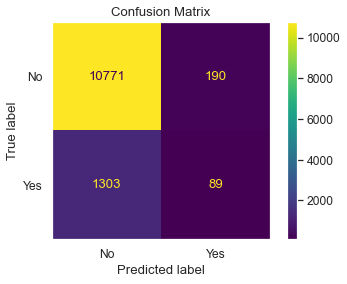

CPU times: user 3.91 s, sys: 53 ms, total: 3.97 s
Wall time: 3.52 s


In [52]:
%%time
# default hyperparameters
params = {'n_neighbors': [5], 'weights':['uniform']}
knn_grid, knn_train, knn_test, knn_time, knn_params, knn_results = model_executor(knn, cv_fold, params, scorer)

#### Decision Tree

Training Accuracy:  0.30890
Test Accuracy    :  0.09986
Average Fit Time :  0.03138
Best parameters @ recall of DecisionTreeClassifier(): {'criterion': 'gini'}


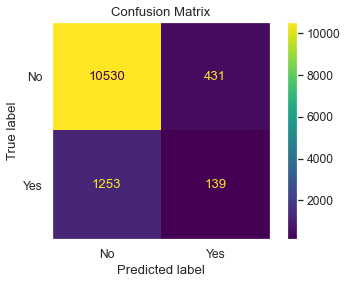

CPU times: user 344 ms, sys: 5.64 ms, total: 350 ms
Wall time: 348 ms


In [53]:
%%time
# default hyperparameters
params = {'criterion': ['gini']}
dtr_grid, dtr_train, dtr_test, dtr_time, dtr_params, dtr_results = model_executor(dtr, cv_fold, params, scorer)

#### SVM

Training Accuracy:  0.01694
Test Accuracy    :  0.00934
Average Fit Time :  19.58361
Best parameters @ recall of SVC(): {'cache_size': 1000}


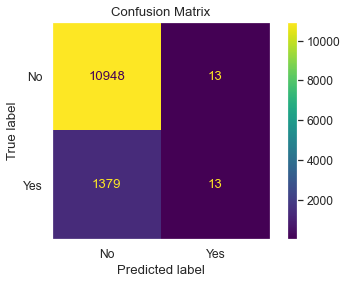

CPU times: user 1min 8s, sys: 628 ms, total: 1min 9s
Wall time: 1min 54s


In [54]:
%%time
# default hyperparameters, allocate more 'cache_size':[1000] for speed up execution
params = {'cache_size':[1000]}
svc_grid, svc_train, svc_test, svc_time, svc_params, svc_results = model_executor(svc, cv_fold, params, scorer, 4)

#### Model Comparison

In [55]:
# Build a dataframe Model	Train Time	Train Accuracy	Test Accuracy
model_df1 = pd.DataFrame({'Model':['Logistic Regression', 'KNN', 'Decision Tree', 'SVM'],
                          'Train Time':[lgr_time, knn_time, dtr_time, svc_time],
                          'Train Accuracy':[lgr_train, knn_train, dtr_train, svc_train],
                          'Test Accuracy':[lgr_test, knn_test, dtr_test, svc_test]
                         })
model_df1

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.013428,0.000000,0.000000
1,KNN,0.012411,0.126886,0.063937
2,Decision Tree,0.031382,0.308901,0.099856
3,SVM,19.583614,0.016939,0.009339


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### Dataset Allocation
Per correlation matrix above, there are some strong correlation among those features per multicollinearity:
 - poutcome strongly correlated with pdays (negative) and previous (positive)
 - emp.var.rate strongly positive correlated with cons.price.idx, euribor3m and nr.employed

In [56]:
# Set full scale dataset
# remove 'duration', 'pdays', 'previous', 'cons.price.idx', 'euribor3m', 'nr.employed' which are strongly correlated
# columns
# poutcome strongly correlated with pdays (negative) and previous (positive)
# emp.var.rate strongly correlated with cons.price.idx, euribor3m and nr.employed

X, y = bank.drop(['duration', 'pdays', 'previous', 'cons.price.idx', 'euribor3m', 'nr.employed', 'y'], axis=1), bank.y
X

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,poutcome,emp.var.rate,cons.conf.idx
0,56,0,0,2,1,1,1,0,5,1,1,0,1.1,-36.4
1,57,1,0,5,0,1,1,0,5,1,1,0,1.1,-36.4
2,37,1,0,5,1,2,1,0,5,1,1,0,1.1,-36.4
3,40,2,0,3,1,1,1,0,5,1,1,0,1.1,-36.4
4,56,1,0,5,1,1,2,0,5,1,1,0,1.1,-36.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,5,0,6,1,2,1,1,11,5,1,0,-1.1,-50.8
41184,46,3,0,6,1,1,1,1,11,5,1,0,-1.1,-50.8
41185,56,5,0,7,1,2,1,1,11,5,2,0,-1.1,-50.8
41186,44,4,0,6,1,1,1,1,11,5,1,0,-1.1,-50.8


In [57]:
# Scale dataframe
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Overlapping Features
Compute overlappin features again for the full dataset

In [58]:
# build a overlapped list
bank_size = bank.groupby(['age', 'job', 'marital', 'education', 'default', 'contact', 'month',
       'campaign', 'poutcome', 'emp.var.rate', 'cons.conf.idx', 'y']).size().groupby(
    ['age', 'job', 'marital', 'education', 'default', 'contact', 'month',
       'campaign', 'poutcome', 'emp.var.rate', 'cons.conf.idx']).size().reset_index()
bank_size[bank_size[0]>1]

,age,job,marital,education,default,contact,month,campaign,poutcome,emp.var.rate,cons.conf.idx,0
2,17,11,1,4,1,1,8,2,1,-2.9,-31.4,2
8,18,11,1,0,1,1,5,1,2,-1.8,-40.0,2
11,18,11,1,0,1,1,9,1,0,-3.4,-29.8,2
23,18,11,1,4,1,1,12,2,0,-3.0,-33.0,2
34,19,11,1,0,1,1,4,3,0,-1.8,-47.1,2
...,...,...,...,...,...,...,...,...,...,...,...,...
29604,82,5,0,7,1,1,10,1,0,-3.4,-26.9,2
29606,82,5,1,2,1,1,10,2,0,-3.4,-26.9,2
29662,88,5,2,2,1,1,3,1,0,-1.8,-50.0,2
29663,88,5,2,2,1,1,3,2,0,-1.8,-50.0,2


In [59]:
# Find out how many data entries is in the overlapped category to see how good a model could be
# These cannot be correctly classified
print('Overlapped Features Rate:', \
    len(bank.merge(bank_size[bank_size[0]>1], on = ['age', 'job', 'marital', 'education', 'default', 'contact', 'month',
       'campaign', 'poutcome', 'emp.var.rate', 'cons.conf.idx'])) / len(bank))
print('Overlapped Features Rows:', \
    len(bank.merge(bank_size[bank_size[0]>1], on = ['age', 'job', 'marital', 'education', 'default', 'contact', 'month',
       'campaign', 'poutcome', 'emp.var.rate', 'cons.conf.idx'])))

Overlapped Features Rate: 0.08900816009325821
Overlapped Features Rows: 3665


9% of full dataset cannot be correctly classified as the remaining features on it cannot distinctly define boundaries in the final outcome. Again, if we assume 50-50 distribution, the best outcome will be 95% but realiably accurate outcome is 91%. 

#### Permutation Importance to Select Features

In [60]:
# permutation importance
# function to execute permutation importance!
def column_importance(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 93, train_size=0.7, test_size=0.3)
    # fit model with training set
    ridge = Ridge(alpha = 0.0000001)
    model = ridge.fit(X_train, y_train)
    # score with test set
    print('model r^2 :', model.score(X_test, y_test))
    # permutation importance
    r = permutation_importance(model, X_test, y_test, n_repeats = 50, random_state = 93)
    print('importance:', r.importances_mean)
    return model, X_test, y_test, pd.DataFrame({"Column":X.columns, "Importance":r.importances_mean}).sort_values(
        by = "Importance", ascending = False)

#### Check Multicollinearity

In [61]:
# Variance Inflation Factor (VIF)
# multicollinearity any feature 5+
def vif(data):
    columns = data.columns
    vif_dict = {}

    for col in data.select_dtypes(include=np.number).columns:
        exclude_col = [i for i in columns if i != col]
        X,y = data[exclude_col], data[col]

        features = data.select_dtypes(exclude=np.number).columns
        features = [c for c in data.select_dtypes(exclude=np.number).columns if c in data.columns]
        ohe_step = make_column_transformer((OneHotEncoder(drop = 'if_binary'), features), remainder="passthrough")
        # fit model with training set
        pipe = Pipeline([('transformer', ohe_step),
                         ('scaler', StandardScaler(with_mean=False)),
                         ('ridge', Ridge(alpha = 10)) ])
        # vif = 1 / (1- R^2)
        r_squared = pipe.fit(X, y).score(X, y)
        if r_squared == 1:
            vif = 0
        else:
            vif = 1 / (1-r_squared)
        vif_dict[col] = vif

    df_vif = pd.DataFrame({"VIF":vif_dict}).sort_values(by = "VIF", ascending = False)
    return df_vif

In [62]:
#y.map({'no':0, 'yes':1})

In [63]:
# Feature importance
model, Xp_test, yp_test, ranking = column_importance(X, y) #y.map({'no':0, 'yes':1}))
ranking

model r^2 : 0.12128358647614934
importance: [ 9.27777470e-04  1.25628222e-03  3.61076094e-04 -1.27753950e-04
  1.98839154e-03  2.41476612e-05  4.11840385e-06  5.34104554e-03
  5.79488815e-04 -1.94367962e-05  4.68954073e-04  4.77717745e-02
  9.30417767e-02  2.69133304e-02]


,Column,Importance
12,emp.var.rate,0.093042
11,poutcome,0.047772
13,cons.conf.idx,0.026913
7,contact,0.005341
4,default,0.001988
1,job,0.001256
0,age,0.000928
8,month,0.000579
10,campaign,0.000469
2,marital,0.000361


In [64]:
# Multicollinearity - anything above 5?
vif(X)

,VIF
emp.var.rate,1.583261
contact,1.563009
month,1.380385
poutcome,1.280853
cons.conf.idx,1.271658
default,1.128615
education,1.104042
age,1.092416
housing,1.063655
loan,1.055819


#### L1 Regularization to Select Features

In [65]:
# Build a coefficient list
Cs = np.logspace(-5, .5)
coef_list = []
for Cval in Cs:
    lgr = LogisticRegression(penalty = 'l1', solver = 'liblinear',
                             C=Cval, random_state=93, max_iter = 1000).fit(X_scaled, y)
    coef_list.append(list(lgr.coef_[0]))
# coefficients
# coef_list[0]
# Build a dataframe
coef_df = pd.DataFrame(coef_list, columns=X.columns, index=Cs)
coef_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,poutcome,emp.var.rate,cons.conf.idx
0.000010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.000013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.000017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.000028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 0, 'Increasing 1/C')

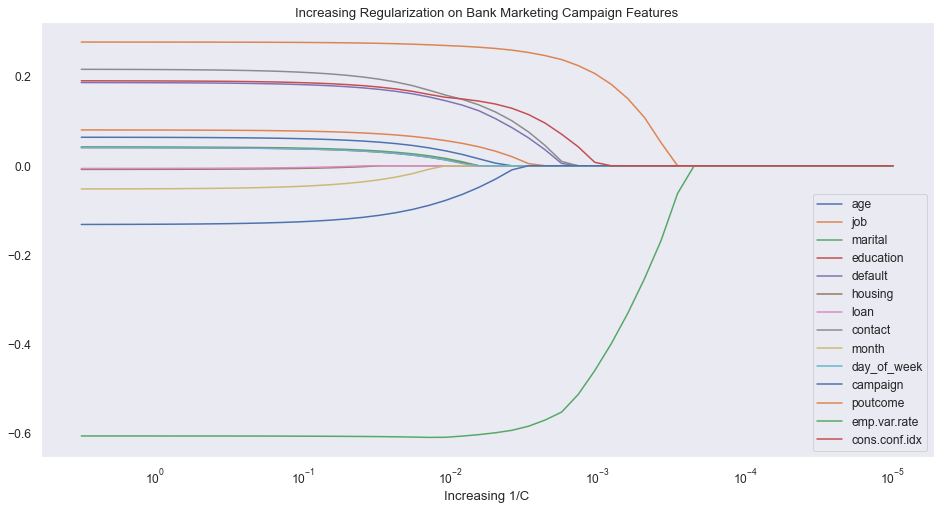

In [66]:
# Visualizing the Coefficient Results
plt.figure(figsize = (16, 8))
#plt.semilogx(coef_df.iloc[:,5:13])
plt.semilogx(coef_df)
plt.gca().invert_xaxis()
plt.grid()
#plt.legend(list(coef_df.columns)[5:13])
plt.legend(list(coef_df.columns))
plt.title('Increasing Regularization on Bank Marketing Campaign Features')
plt.xlabel("Increasing 1/C")
#plt.savefig('images/coefficient.png')

Features `loan`, `housing`, `day_of_week` and `month` seem less important in this plot. `loan` and `day_of_week` features are also bottom 2 in the `permutation importance` list.

Also, see if L1 regulation would remove any of less important features

In [67]:
# Check to see what is kept
selector = SelectFromModel(estimator=LogisticRegression(C = 0.01, penalty = 'l1', max_iter = 1000,
                                                        solver = 'liblinear', random_state = 93)).fit(X, y)
# top features by L1 regulation
print(selector.get_feature_names_out(X.columns))

['age' 'job' 'education' 'default' 'contact' 'month' 'campaign' 'poutcome'
 'emp.var.rate' 'cons.conf.idx']


### Adjust Dataset and Split
After the feature engineering methods revealed bottom features, we can remove `loan`, `housing`, and `day_of_week` columns and split dataset again in to train and test since there is agreement on those columns by L1 Regularization and multicollinearity. Beyond that, the multicollienarity check by Variance Inflation Factor (VIF) did not point out any features. Going with the scaled dataset after removing 3 less important features from the X dataset.
#### Apply SMOTE method and Standardization
The dataset is imbalanced having 11% acceptance and 89% not. Apply SMOTE to have equal number of data entries on either classes.
Standardization is applied to avoid small features penalized heavily by the penalty term since features are skewed.

In [68]:
# print y before and after applying SMOTE
print(Counter(y))
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
print(Counter(y))
# Scale new dataset
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

Counter({0: 36537, 1: 4639})
Counter({0: 36537, 1: 36537})


In [69]:
# Remove loan and housing features
# use scaled dataset to split
X_train, X_test, y_train, y_test = train_test_split(X_scaled.drop(['loan', 'housing', 'day_of_week'], axis=1), y,
                                                    random_state = 93, test_size = 0.3, stratify = y)

In [70]:
# Set scores to evaluate
#scorings = ['accuracy', 'precision', 'recall', 'roc_auc']
#scorings = ['recall']
scorings = ['roc_auc']

In [71]:
X_test.columns

Index(['age', 'job', 'marital', 'education', 'default', 'contact', 'month',
       'campaign', 'poutcome', 'emp.var.rate', 'cons.conf.idx'],
      dtype='object')

### Logistic Regression

Training Accuracy:  0.75939
Test Accuracy    :  0.76090
Average Fit Time :  0.03622
Best parameters @ roc_auc of LogisticRegression(): {'C': 100, 'max_iter': 1000, 'solver': 'lbfgs'}


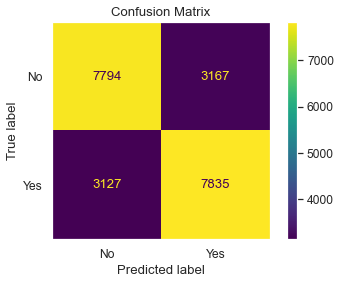

CPU times: user 21.9 s, sys: 489 ms, total: 22.4 s
Wall time: 2.84 s


In [72]:
%%time
# hyperparameter values for LogisticRegression()
lgr = LogisticRegression()
params = {'solver':['lbfgs', 'liblinear'], 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], 'max_iter':[500]}
#          'max_iter':[1000], 'class_weight':[{0:.87, 1:.13}]}
for scorer in scorings:
    lgr_grid, lgr_train, lgr_test, lgr_time, lgr_params, lgr_results = model_executor(lgr, cv_fold, params, scorer)

### KNN

Training Accuracy:  0.99581
Test Accuracy    :  0.90890
Average Fit Time :  0.03263
Best parameters @ roc_auc of KNeighborsClassifier(): {'n_jobs': 5, 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}


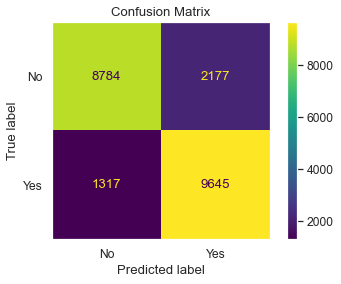

CPU times: user 43 s, sys: 1.37 s, total: 44.4 s
Wall time: 40 s


In [73]:
%%time
# KNN
# hyperparameter values
params = {'n_neighbors': range(3, 15, 2), 'weights':['uniform', 'distance'], 'p':[1, 2], 'n_jobs':[5]}
for scorer in scorings:
    knn_grid, knn_train, knn_test, knn_time, knn_params, knn_results = model_executor(knn, cv_fold, params, scorer)

### Decision Tree

Training Accuracy:  0.93030
Test Accuracy    :  0.88927
Average Fit Time :  0.07017
Best parameters @ roc_auc of DecisionTreeClassifier(): {'criterion': 'entropy', 'max_depth': 33, 'min_samples_leaf': 2, 'min_samples_split': 0.001}


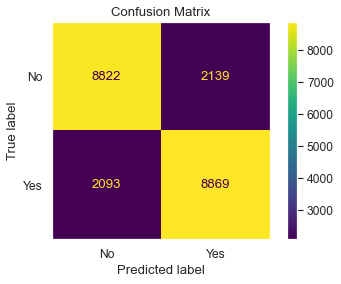

CPU times: user 30 s, sys: 1.4 s, total: 31.4 s
Wall time: 31.4 s


In [74]:
%%time
# Decision Tree
# hyperparameter values
params = {'max_depth': [5, 13, 23, 25, 27, 29, 30, 33, 34, 43],
          'min_samples_split': [0.00001, 0.0001, 0.001, 0.01],
          'criterion': ['gini', 'entropy'],
          'min_samples_leaf': [2]
         }
for scorer in scorings:
    dtr_grid, dtr_train, dtr_test, dtr_time, dtr_params, dtr_results = model_executor(dtr, cv_fold, params, scorer)

### SVM

/Applications/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training Accuracy:  0.74700
Test Accuracy    :  0.74811
Average Fit Time :  106.93197
Best parameters @ roc_auc of SVC(): {'C': 0.001, 'cache_size': 1000, 'gamma': 0.01, 'kernel': 'rbf'}


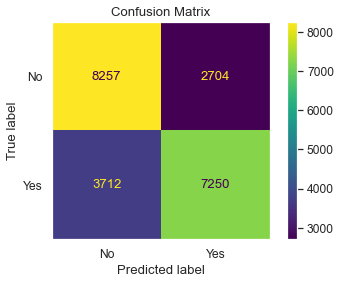

CPU times: user 9min 24s, sys: 1.43 s, total: 9min 26s
Wall time: 22min 5s


In [75]:
%%time
# SVM
# hyperparameter values - poly with degree=2?
params = {'kernel': ['rbf'], 'gamma': [0.001, 0.01],
          'C':[0.0001, 0.001], 'cache_size':[1000]}
for scorer in scorings:
    svc_grid, svc_train, svc_test, svc_time, svc_params, svc_results = model_executor(svc, cv_fold, params, scorer, 4)

In [76]:
tend = datetime.now()
print(tstart, '-', tend)
print(tend-tstart)

2022-07-18 12:20:54.234541 - 2022-07-18 12:46:23.716077
0:25:29.481536


In [77]:
# Build a dataframe Model	Train Time	Train Accuracy	Test Accuracy
model_df2 = pd.DataFrame({'Model':['Logistic Regression', 'KNN', 'Decision Tree', 'SVM'],
                          'Train Time':[lgr_time, knn_time, dtr_time, svc_time],
                          'Train Accuracy':[lgr_train, knn_train, dtr_train, svc_train],
                          'Test Accuracy':[lgr_test, knn_test, dtr_test, svc_test]
                         })
model_df2

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.036220,0.759387,0.760900
1,KNN,0.032628,0.995813,0.908895
2,Decision Tree,0.070174,0.930301,0.889269
3,SVM,106.931974,0.747004,0.748109


In [78]:
# # Full scale dataset
# X, y = bank.drop(['duration', 'y'], axis=1), bank.y
# X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
# X_scaled

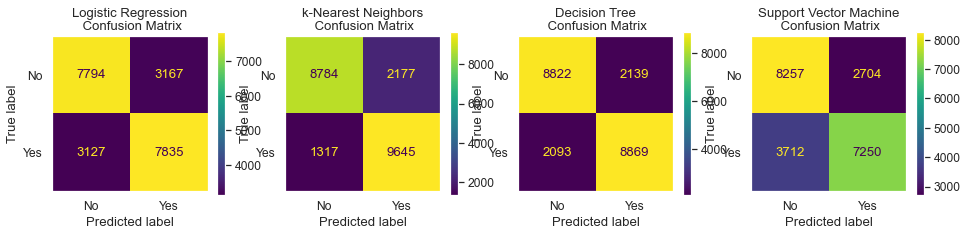

CPU times: user 2min, sys: 301 ms, total: 2min
Wall time: 1min 51s


In [79]:
%%time
# plot confusion matrices as summary side-by-side
fig, ax = plt.subplots(1, 4, figsize = (16, 3))
ConfusionMatrixDisplay.from_predictions(y_test, lgr_grid.predict(X_test), display_labels = ['No', 'Yes'], ax = ax[0])
ConfusionMatrixDisplay.from_predictions(y_test, knn_grid.predict(X_test), display_labels = ['No', 'Yes'], ax = ax[1])
ConfusionMatrixDisplay.from_predictions(y_test, dtr_grid.predict(X_test), display_labels = ['No', 'Yes'], ax = ax[2])
ConfusionMatrixDisplay.from_predictions(y_test, svc_grid.predict(X_test), display_labels = ['No', 'Yes'], ax = ax[3])
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[3].grid(False)
ax[0].set_title('Logistic Regression\n Confusion Matrix')
ax[1].set_title('k-Nearest Neighbors\n Confusion Matrix')
ax[2].set_title('Decision Tree\n Confusion Matrix')
ax[3].set_title('Support Vector Machine\n Confusion Matrix')
plt.show()

#### Model Results
**k-Nearest Neighbors** with _91%_ is pretty close to our performance metric projection due to `feature overlapping`. **Decision Tree** is pretty good too, their train time is pretty close 31 seconds each and reasonable with the magnitude of data. However, Logistic Regression is one click better than Support Vector Machine and fastest train time. SVM took over an hour to train with no parallelism and performed worst in both test accuracy and train time.

|Model|	Train Time|	Train Accuracy|	Test Accuracy|
|-----|-----------|---------------|--------------|
|	Logistic Regression|	0.033166|	0.759782|	0.763205|
|	k-Nearest Neighbors|	0.030518|	0.995653|	0.908220|
|	Decision Tree|	0.071775|	0.929373|	0.891593|
|	Support Vector Machine|	55.611333|	0.746876|	0.750658|


CPU times: user 1min 55s, sys: 192 ms, total: 1min 56s
Wall time: 1min 48s


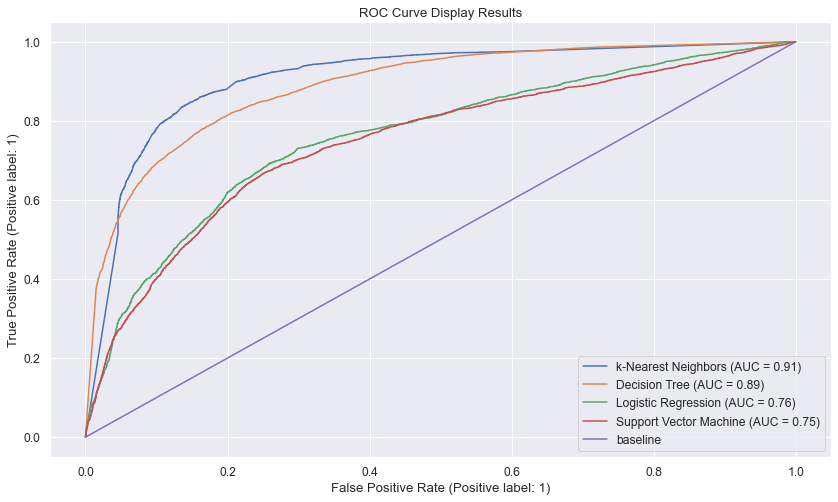

In [82]:
%%time
fig, ax = plt.subplots(figsize=(14,8))
RocCurveDisplay.from_estimator(knn_grid, X_test, y_test, pos_label = 1, ax = ax,
                               label = 'k-Nearest Neighbors (AUC = 0.91)')
RocCurveDisplay.from_estimator(dtr_grid, X_test, y_test, pos_label = 1, ax = ax,
                               label = 'Decision Tree (AUC = 0.89)')
RocCurveDisplay.from_estimator(lgr_grid, X_test, y_test, pos_label = 1, ax = ax,
                               label = 'Logistic Regression (AUC = 0.76)')
RocCurveDisplay.from_estimator(svc_grid, X_test, y_test, pos_label = 1, ax = ax,
                               label = 'Support Vector Machine (AUC = 0.75)')
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline')
plt.title('ROC Curve Display Results')
plt.legend()
plt.grid(True)

In [81]:
# %%time
# fig, ax = plt.subplots(figsize=(14,8))
# RocCurveDisplay.from_estimator(lgr_grid, X_test, y_test, pos_label = 1, ax = ax)
# RocCurveDisplay.from_estimator(knn_grid, X_test, y_test, pos_label = 1, ax = ax)
# RocCurveDisplay.from_estimator(dtr_grid, X_test, y_test, pos_label = 1, ax = ax)
# RocCurveDisplay.from_estimator(svc_grid, X_test, y_test, pos_label = 1, ax = ax)
# plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline')
# plt.title('ROC Curve Display Results')
# plt.legend()
# plt.grid(True)

##### Questions
What are next steps?
1. I briefly highlighted "unknown" values in categorical variables, `job` and `marital` features are highly influential, those should be removed from the dataset to try out those models
2. Secondly, `overlapping features` should be addressed in the dataset which brings ambiquity to those models, once they are cleared, models should reevaluated for better performance
3. SVM could be tried with poly kernel and higher degrees, however, it is very CPU-intensive should be on a dedicated computer